In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 GB 37.4 MB/s eta 0:00:01tcmalloc: large alloc 1837596672 bytes == 0x3cbe000 @  0x7f46a3e601e7 0x4d30a0 0x4d312c 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2
tcmalloc: large alloc 2296995840 bytes == 0x71536000 @  0x7f46a3e61615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 GB 35.4 MB/s eta 0:00:01tcmalloc: large alloc 18

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.30.0


In [ ]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2023-01-14 21:36:31--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.204, 47.246.48.211, 47.246.48.206, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  83.8MB/s    in 2.2s    

2023-01-14 21:36:34 (83.8 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [ ]:
!ls
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

checkpoints   docs	   mmsegmentation.egg-info  README_zh-CN.md   setup.py
CITATION.cff  LICENSE	   model-index.yml	    requirements      tests
configs       LICENSES.md  projects		    requirements.txt  tools
demo	      MANIFEST.in  pytest.ini		    resources
docker	      mmseg	   README.md		    setup.cfg


/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


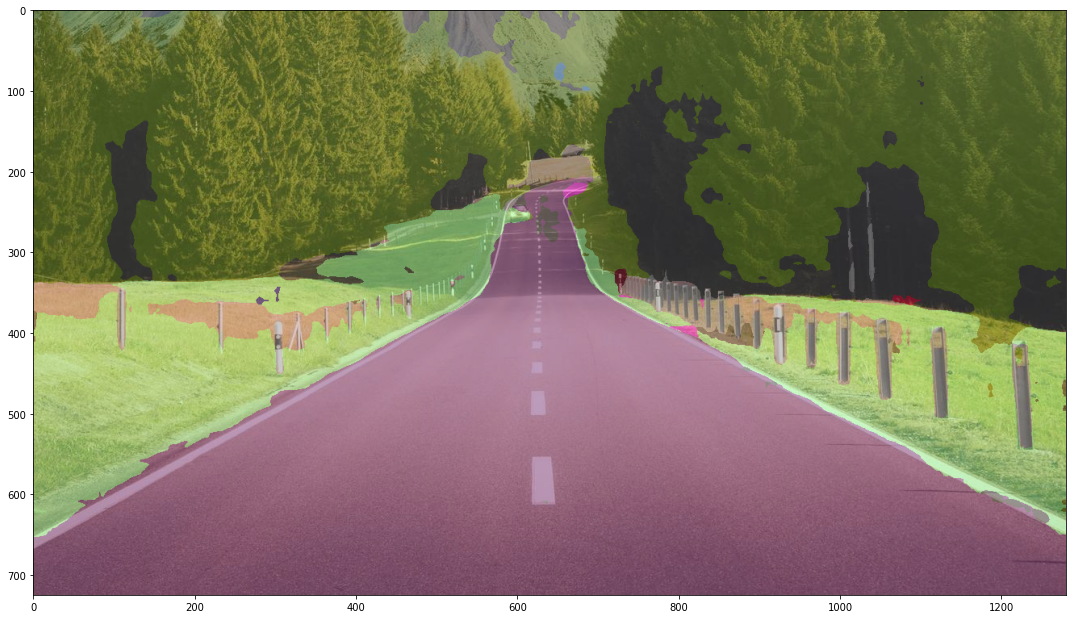

In [ ]:

# test a single image
img_name = 'irl.jpg'
result = inference_segmentor(model, img_name)
# show the results
show_result_pyplot(model, img_name, result, get_palette('cityscapes'))

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


p_mat = np.array([[ 640,     0,   640,  2176 ],[   0,   480,   480,   552 ],[   0,     0,     1,     1.4]])

In [ ]:
def decompose_projection_matrix(p):
    out = cv2.decomposeProjectionMatrix(p)
    k = out[0]
    r = out[1]
    t = out[2]
    t = t/t[3]
    return k, r, t

intrinsic, rotation, position = decompose_projection_matrix(p_mat)

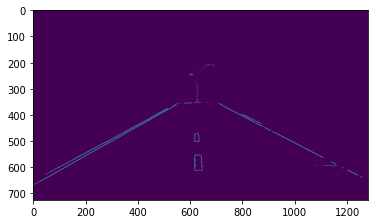

In [ ]:
img = cv2.imread(img_name)

def detect_lanes(img, segmentation_result):
    grey_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filtered = cv2.GaussianBlur(grey_scale, (5,5), cv2.BORDER_DEFAULT)
    edges = cv2.Canny(filtered,50,100)
    road = np.array(segmentation_result == 0, dtype=int)[0]
    lanes = edges * road
    plt.imshow(lanes)
    return lanes

lanes = detect_lanes(img, np.array(result))

def filter_lane_color(lanes, original_img):
    img_hue = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([20,100,100],dtype="uint8")
    upper_bound = np.array([200,255,255],dtype="uint8")
    yellow_found = cv2.inRange(img_hue, lower_bound, upper_bound)
    grey_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(img_hue)
    white_found = cv2.inRange(grey_scale, 150, 255)
    filtered_lanes = lanes * cv2.bitwise_or(yellow_found, white_found)
    plt.imshow(filtered_lanes)

filter_lane_color(lanes, img)

IndexError: ignored